In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch as pt
import numpy as np

In [3]:
from allocineutil import get_rating_class, get_rating_value

In [4]:
train = pd.read_pickle("dataset/train.bin.zst")
test = pd.read_pickle("dataset/test.bin.zst")
dev = pd.read_pickle("dataset/dev.bin.zst")

In [5]:
print(len(train), len(test), len(dev))

665962 85847 100400


In [6]:
train

,movie,name,user_id,note,commentaire
review_id,,,,,
2413179,126693,sebwalker,Z20060107094521777557137,5.0,un Harry potter sombre et emouvant tjrs aussi ...
2472213,114782,Phil H,Z20060318182114470983716,2.5,"Je l'ai entendu, attendu et finalement vu hier..."
2472232,128188,Phil H,Z20060318182114470983716,4.0,"Vu hier soir, un excellent film bourré de jeux..."
2487223,126678,spider1990,Z20070429202537840527684,0.5,"Le film contient quelques beaux décors, mais ç..."
2835340,128188,spider1990,Z20070429202537840527684,3.0,L'homme araignée est de retour pour une nouvel...
...,...,...,...,...,...
1007285816,241132,Agathe Nogues,Z20200519030838474204775,5.0,Un film incroyable! Ce film est à la fois touc...
1007286675,247810,Mina Traoré,Z20200519042856506959012,1.0,On a perdu 1h 30 de notre vie pour ce film inc...
1007288017,230726,rouxguigui,Z20090703110154173994469,3.5,"Un film gentil, mignon et avec de belles image..."


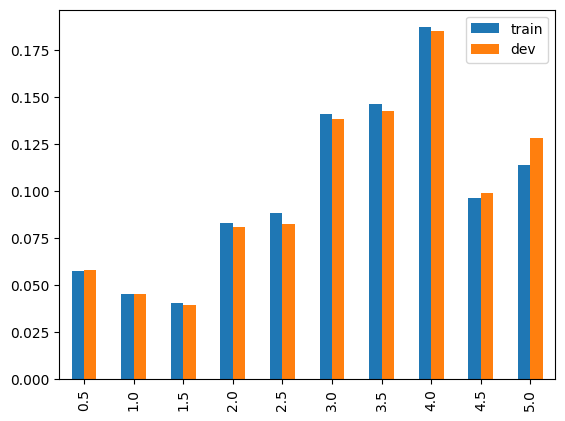

<AxesSubplot:>

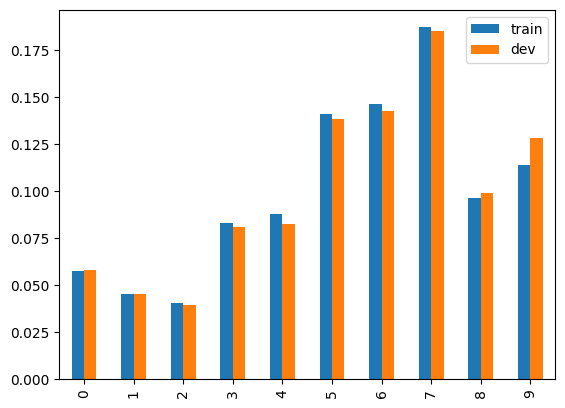

In [7]:
note_values = pd.DataFrame()
note_values["train"] = train["note"].value_counts(normalize=True).sort_index()
note_values["dev"] = dev["note"].value_counts(normalize=True).sort_index()
note_values.plot(kind="bar")
plt.show()

three_classes = pd.DataFrame()
three_classes["train"] = train["note"].transform(get_rating_class).value_counts(normalize=True).sort_index()
three_classes["dev"] = dev["note"].transform(get_rating_class).value_counts(normalize=True).sort_index()
three_classes.plot(kind="bar")

In [8]:
# import numpy as np
# note_test = train
# note_test["len"] = note_test["commentaire"].transform(lambda text: len(text.split()))
# note_test.groupby(pd.cut(note_test.len, np.linspace(0,6000,20))).note.mean().plot.barh(figsize=(10, 10))


<AxesSubplot:title={'center':'Rating distribution for 20 randomly sampled movies (with >100 reviews)'}, ylabel='movie'>

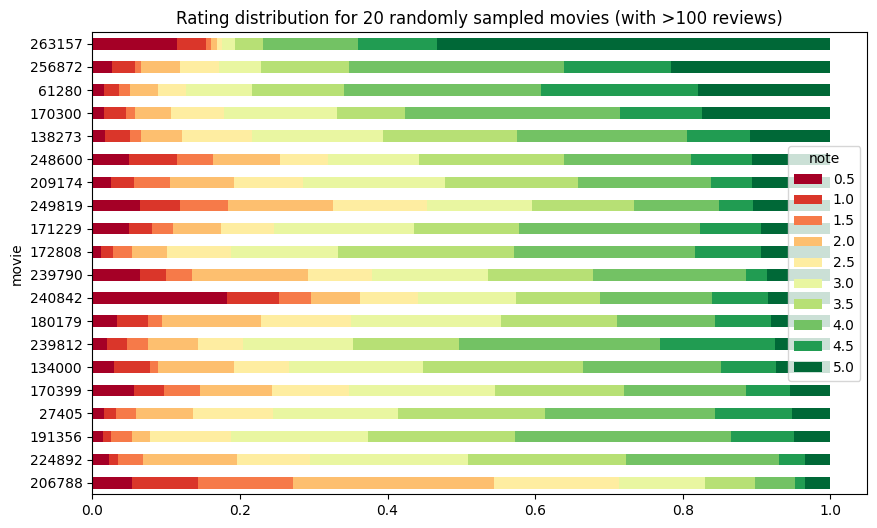

In [9]:
film_subset = dev

# remove movies with less than 100 reviews
film_subset = film_subset[film_subset.groupby("movie")["movie"].transform("count").ge(100)]

# make a table from the normalized frequency of each rating for each movie
film_subset = film_subset.groupby("movie").note.value_counts(normalize=True).unstack()

# sample 20 movies and create stacked horizontal bar plots of the ratings for each movie using a green-to-red colormap, sorted by the frequency of the 5-star rating
film_subset.sample(20).sort_values(5, ascending=True).plot.barh(title="Rating distribution for 20 randomly sampled movies (with >100 reviews)", stacked=True, colormap="RdYlGn", figsize=(10, 6))

Text(0.5, 0, 'Average rating')

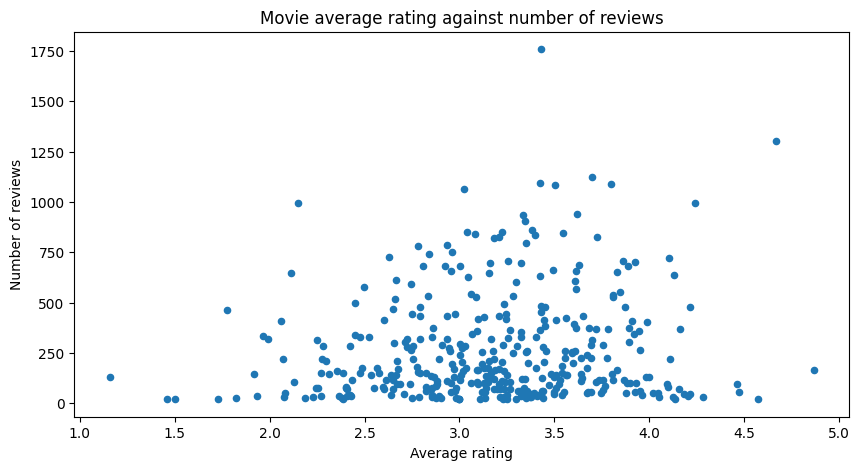

In [10]:
# plot movies average rating against number of reviews
film_subset = dev

# remove movies with less than 20 reviews
film_subset = film_subset[film_subset.groupby("movie")["movie"].transform("count").ge(20)]

film_subset = film_subset.groupby("movie").agg({"note": "mean", "movie": "count"})
film_subset.plot.scatter(y="movie", x="note", title="Movie average rating against number of reviews", figsize=(10, 5))
plt.ylabel("Number of reviews")
plt.xlabel("Average rating")

In [11]:
len(dev["user_id"].unique())

35344

In [12]:
len(dev["name"].unique())

32044

Text(0, 0.5, 'amount of reviews (non-linear scale!)')

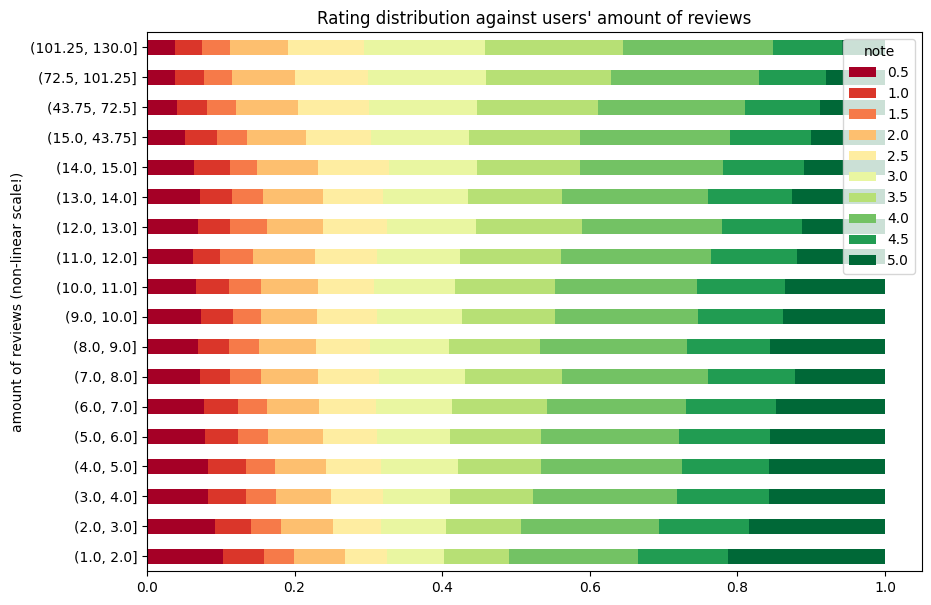

In [13]:
# bin users by the number of reviews they have written into 10 bins
user_subset = train
bins = np.concatenate((np.linspace(1, 14, 14), np.linspace(15, 130, 5)))

user_subset["bin"] = pd.cut(user_subset.groupby("user_id")["user_id"].transform("count"), bins)

# make a table from the normalized frequency of each rating for each user bin
user_subset = user_subset.groupby("bin").note.value_counts(normalize=True).unstack()

# create stacked horizontal bar plots of the ratings for each user bin using a green-to-red colormap
user_subset.plot.barh(title="Rating distribution against users' amount of reviews", stacked=True, colormap="RdYlGn", figsize=(10, 7))
plt.ylabel("amount of reviews (non-linear scale!)")

<AxesSubplot:title={'center':'Correlation with rating'}>

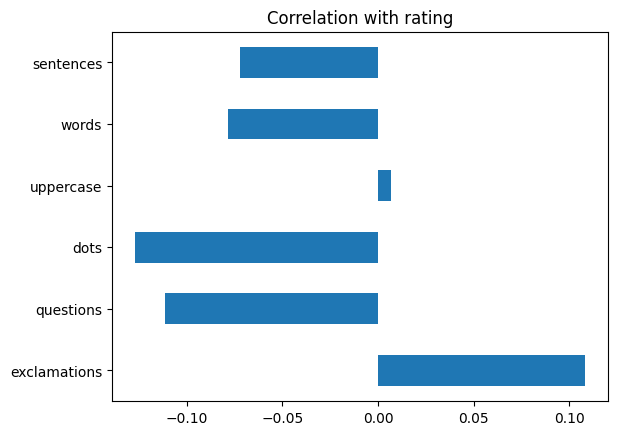

In [14]:
# count the amount of exclamation marks in each review
dev["exclamations"] = dev["commentaire"].transform(lambda text: text.count("!"))

# count the amount of question marks in each review
dev["questions"] = dev["commentaire"].transform(lambda text: text.count("?"))

# count the number of dots in each review
dev["dots"] = dev["commentaire"].transform(lambda text: text.count("."))

# count the amount of uppercase words in each review
dev["uppercase"] = dev["commentaire"].transform(lambda text: sum(1 for word in text.split() if word.isupper()))

# count the amount of words in each review
dev["words"] = dev["commentaire"].transform(lambda text: len(text.split()))

# count the number of sentences in each review
dev["sentences"] = dev["commentaire"].transform(lambda text: len(list(word for word in text.split(".") if len(word) != 0)))

# plot the correlation between every feature and the rating
dev[["exclamations", "questions", "dots", "uppercase", "words", "sentences", "note"]].corr("spearman").note.drop("note").plot.barh(title="Correlation with rating")

In [15]:
state = pt.load("model.ckpt", map_location=pt.device("cpu"))

In [16]:
from model import AllocinePredictor
model = AllocinePredictor("model.baseline10c.epoch4.ckpt", device="cpu")

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
def test_for(text_list, ground_truth=None):
    results = dict(zip(text_list, model(text_list)))

    for text, result in results.items():
        print(f"{result.rating_class} | regression: {result.rating_regression:.2f} | \"{text}\"")

In [31]:
test_for([
    "J'ai adoré ce film! Christopher Nolan est un génie. Il est vraiment à voir. Un peu mou sur la fin, dommage.",
    "Comme d'habitude, la médiocrité de ce film est à la hauteur de Christopher Nolan. Je déteste ce type. Gnagnagna.",
    "Franchement... pas génial. Le jeu d'acteur est nul. Cela dit, le scénario est pas mal. Je ne le conseille pas.",
    "Rien à redire: c'est magique!",
    "Pwalala, j'ai pas pu tenir jusqu'au bout. Jamais je ne me suis levé pour quitter le cinéma. C'est dire.",
    "HAHAHA c'était trop drôle! J'ai adoré! Je le conseille à tout le monde!",
    "HAHAHA c'était trop nul à chier putain! J'avais envie de crever! Je le déconseille à tout le monde!",
    "Une oeuvre franchement très curieuse. Je ne sais pas trop quoi en penser. J'ai l'impression d'avoir raté des trucs, mais l'ambiance est incroyable. Je conseille juste pour l'expérience.",
    "ptdr c'est déprimant de nullité. nul nul nul",
    "j'ai bien aimé la partie où il y a des trucs qui se passent",
    "That movie was rather decent.",
    "Utter crap!",
    "I have never enjoyed a movie that much in my life."
])

4.5 | regression: 4.24 | "J'ai adoré ce film! Christopher Nolan est un génie. Il est vraiment à voir. Un peu mou sur la fin, dommage."
0.5 | regression: 0.81 | "Comme d'habitude, la médiocrité de ce film est à la hauteur de Christopher Nolan. Je déteste ce type. Gnagnagna."
2.0 | regression: 1.77 | "Franchement... pas génial. Le jeu d'acteur est nul. Cela dit, le scénario est pas mal. Je ne le conseille pas."
5.0 | regression: 4.85 | "Rien à redire: c'est magique!"
0.5 | regression: 0.43 | "Pwalala, j'ai pas pu tenir jusqu'au bout. Jamais je ne me suis levé pour quitter le cinéma. C'est dire."
5.0 | regression: 4.86 | "HAHAHA c'était trop drôle! J'ai adoré! Je le conseille à tout le monde!"
0.5 | regression: 0.36 | "HAHAHA c'était trop nul à chier putain! J'avais envie de crever! Je le déconseille à tout le monde!"
3.5 | regression: 3.31 | "Une oeuvre franchement très curieuse. Je ne sais pas trop quoi en penser. J'ai l'impression d'avoir raté des trucs, mais l'ambiance est incroyable.

In [19]:
text_list = dev["commentaire"][:20]
test_for(text_list)

/tmp/ipykernel_3824/2794498800.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  text_list = dev["commentaire"][:20]
/local_disk/hades/users/sdelangen/ceri-innov-tp/model.py:71: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return (seq[pos:pos + size] for pos in range(0, len(seq), size))
Token indices sequence length is longer than the specified maximum sequence length for this model (734 > 512). Running this sequence through the model will result in indexing errors


3.5 | regression: 3.31 | "Trente ans auront fallu pour attendre l'adaptation du célèbre reporter, mais les moyens utilisés nous laissent sans voix et nous font vite oublier cette longue attente au profit d'une technologie révolutionnaire. Ils ont ajouté des moments hilarants qui s'enchaînent vite en essayant d'améliorer certain point de la BD. Pour les tintinophiles ils remarqueront vite les nombreuses différences avec la BD, même s'ils ont essayé de rester dans une histoire des plus plausibles ils ont délaissé certains éléments qu'on aurait voulu voir. La performance capture est séduisante grâce à des acteurs attachants qui savent y faire dans ce domaine, mais on sent qu'il manque quelque chose à l'animation pour qu'il soit au top du progrès. Seul Spielberg était de taille pour relancer la franchise après des précédents films d'animations de Tintin moins convaincants et on espère que les suites respecteront plus la BD avec des péripéties plus alléchantes."
3.5 | regression: 3.38 | "Le